# Training and validating LSTM + MPL model with the WHXE loss function

## Imports

In [1]:
import time
import pickle
import platform
import os
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from LSTM_model import get_LSTM_Classifier
from dataloader import LSSTSourceDataSet, load, get_augmented_data, get_static_features, ts_length
from loss import WHXE_Loss
from taxonomy import get_taxonomy_tree, get_prediction_probs, get_highest_prob_path, plot_colored_tree
from vizualizations import make_gif, plot_confusion_matrix, plot_roc_curves
from interpret_results import get_conditional_probabilites, save_all_cf_and_rocs

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras

2024-06-11 04:54:53.210471: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 04:54:53.952966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 04:54:53.954507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 04:54:54.123337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-11 04:54:54.451721: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Tensorflow version", tf.__version__)
print("Python version", platform.python_version())

Tensorflow version 2.15.0
Python version 3.10.12


## Load and balance the tensors:

This step takes a while because it has load from disc to memory...

In [3]:
X_ts = load("processed/train/x_ts.pkl")
X_static = load("processed/train/x_static.pkl")
Y = load("processed/train/y.pkl")
astrophysical_classes = load("processed/train/a_labels.pkl")

Small step to convert X_static from a dictionary to an array

In [4]:
for i in range(len(X_static)):
    
    if i%1000 == 0:
        print(f"{(i/len(X_static) * 100):.3f} %", end="\r")
        
    X_static[i] = get_static_features(X_static[i])

Balance the data set in some way

In [5]:
max_class_count = 13000

X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
lengths_balanced = []
astrophysical_classes_balanced = []

for c in np.unique(astrophysical_classes):

    idx = np.where(np.array(astrophysical_classes) == c)[0]
    
    if len(idx) > max_class_count:
        idx = idx[:max_class_count]
 
    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]

# Print summary of the data set used for training and validation
a, b = np.unique(astrophysical_classes_balanced, return_counts=True)
data_summary = pd.DataFrame(data = {'Class': a, 'Count': b})
data_summary

,Class,Count
0,AGN,13000
1,CART,8207
2,Cepheid,13000
3,Delta Scuti,13000
4,Dwarf Novae,8025
5,EB,13000
6,ILOT,7461
7,KN,4426
8,M-dwarf Flare,1859
9,PISN,13000


Free up some memory

In [6]:
del X_ts, X_static, Y, astrophysical_classes

Split into train and validation

In [7]:
val_fraction = 0.05
X_ts_train, X_ts_val, X_static_train, X_static_val, Y_train, Y_val, astrophysical_classes_train, astrophysical_classes_val = train_test_split(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, shuffle=True, random_state = 40, test_size = val_fraction)

Free up some more memory

In [8]:
del X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced

## Define the Loss function, criterion, etc.

In [30]:
# Loss and optimizer
tree = get_taxonomy_tree()
loss_object = WHXE_Loss(tree, astrophysical_classes_train, alpha=0) 
criterion = loss_object.compute_loss

In [31]:
optimizer = keras.optimizers.Adam(learning_rate=5e-4)

In [32]:
# Inputs for model
ts_dim = 5
static_dim = len(X_static_train[0])
output_dim = 26
latent_size = 64

num_epochs = 50
batch_size = 2048

## Train the classifier using WHXE loss and save the model

In [33]:
model = get_LSTM_Classifier(ts_dim, static_dim, output_dim, latent_size)
keras.utils.plot_model(model, to_file='lstm.pdf', show_shapes=True, show_layer_names=True)
plt.close()

In [34]:
@tf.function
def train_step(x_ts, x_static, y):
    with tf.GradientTape() as tape:
        logits = model((x_ts, x_static), training=True)
        loss_value = criterion(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value


Start of epoch 0
Augmenting time series lengths...
Avg training loss: 0.9467


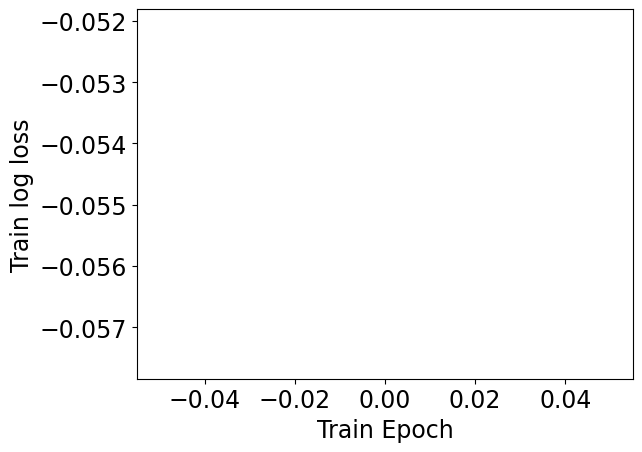

Time taken: 37.95s

Start of epoch 1
Augmenting time series lengths...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Avg training loss: 0.8634


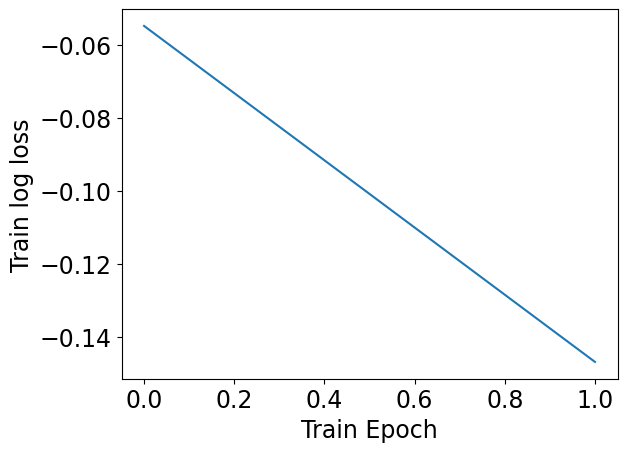

Time taken: 32.09s

Start of epoch 2
Augmenting time series lengths...
Avg training loss: 0.8011


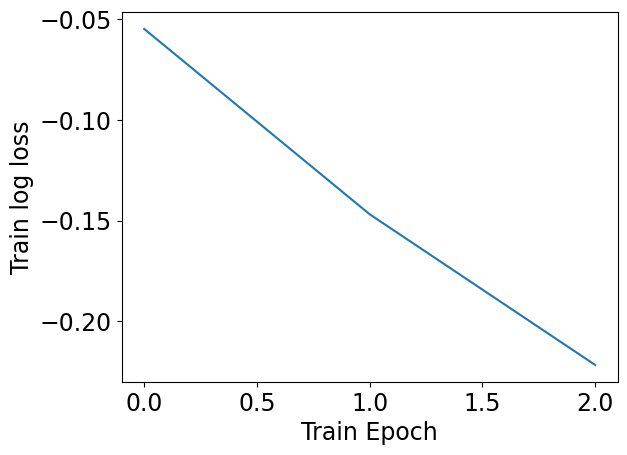

Time taken: 33.83s

Start of epoch 3
Augmenting time series lengths...
Avg training loss: 0.7925


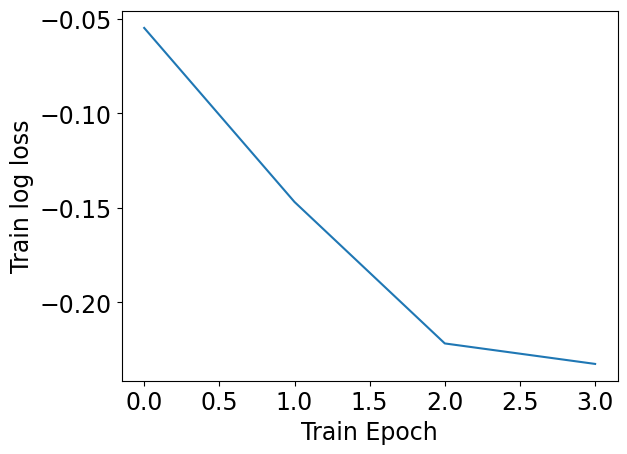

Time taken: 31.37s

Start of epoch 4
Augmenting time series lengths...
Avg training loss: 0.7887


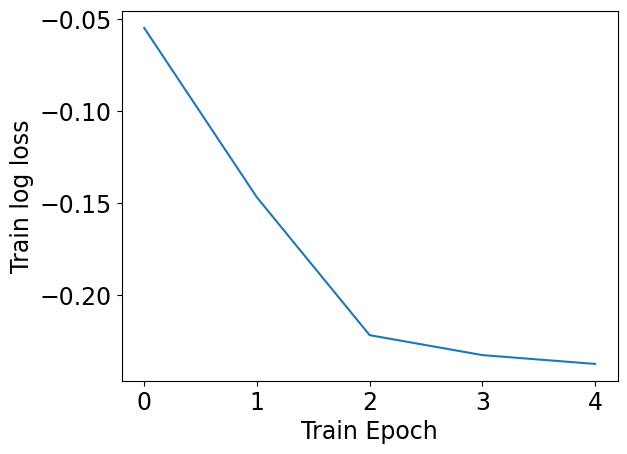

Time taken: 29.75s

Start of epoch 5
Augmenting time series lengths...
Avg training loss: 0.7235


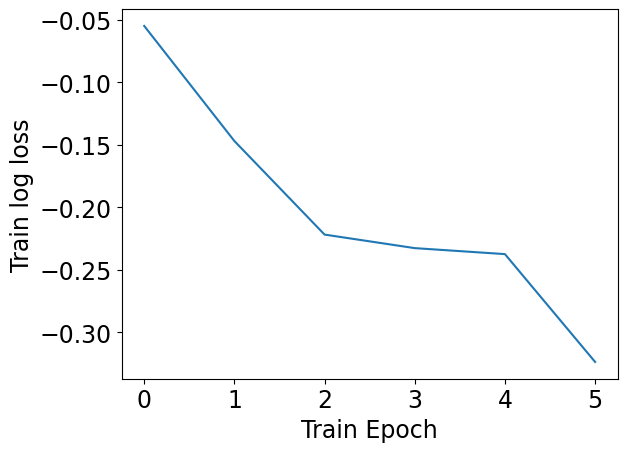

Time taken: 34.37s

Start of epoch 6
Augmenting time series lengths...
Avg training loss: 0.7673


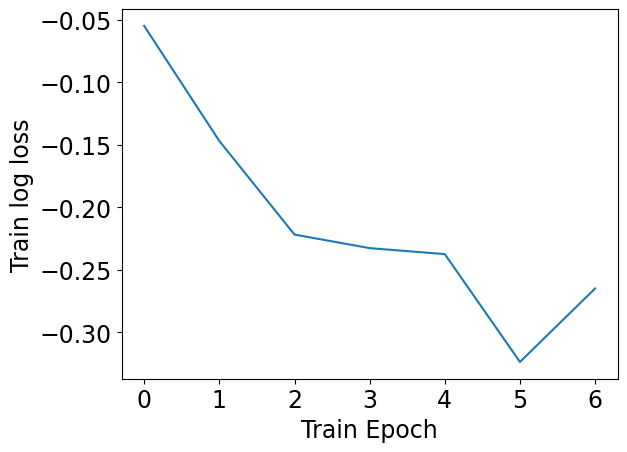

Time taken: 28.44s

Start of epoch 7
Augmenting time series lengths...
Avg training loss: 0.7335


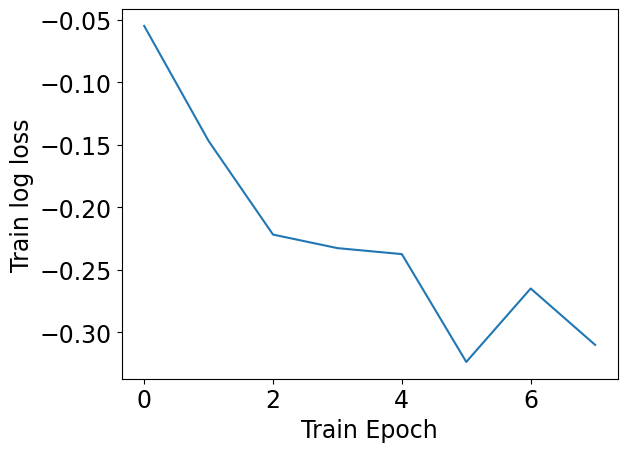

Time taken: 29.68s

Start of epoch 8
Augmenting time series lengths...
Avg training loss: 0.7237


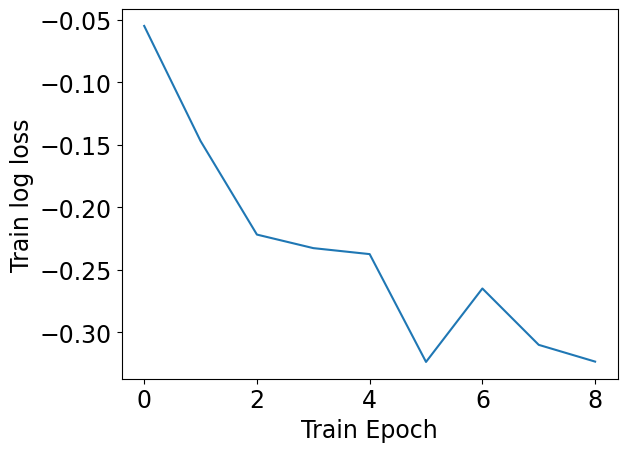

Time taken: 32.37s

Start of epoch 9
Augmenting time series lengths...
Avg training loss: 0.7595


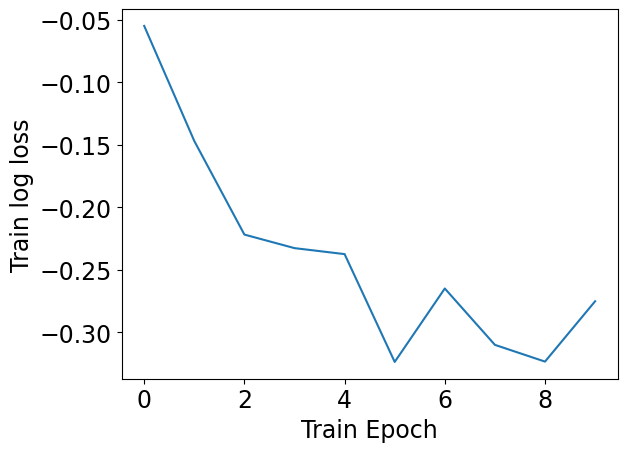

Time taken: 27.24s

Start of epoch 10
Augmenting time series lengths...
Avg training loss: 0.7536


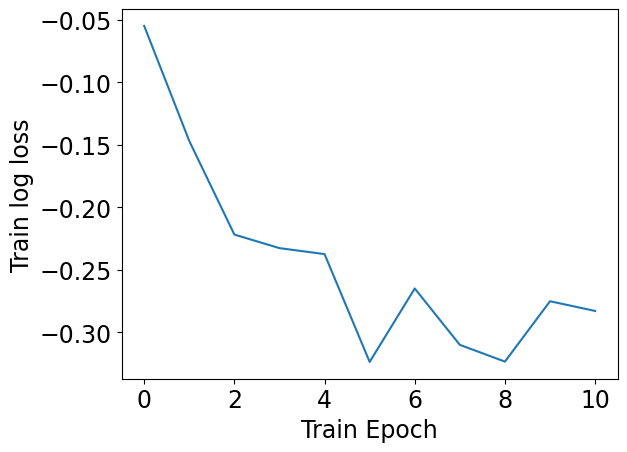

Time taken: 29.01s

Start of epoch 11
Augmenting time series lengths...
Avg training loss: 0.6665


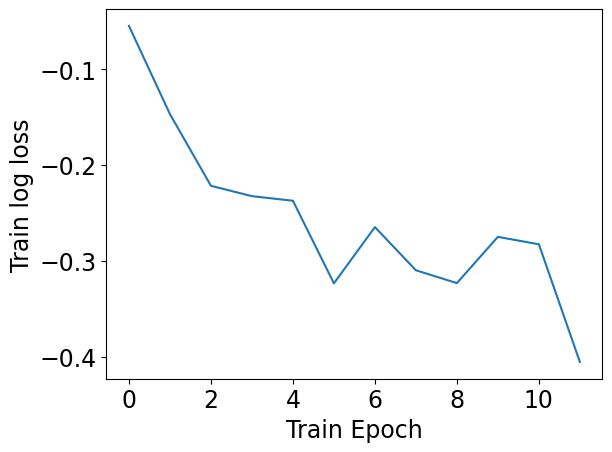

Time taken: 34.86s

Start of epoch 12
Augmenting time series lengths...
Avg training loss: 0.6233


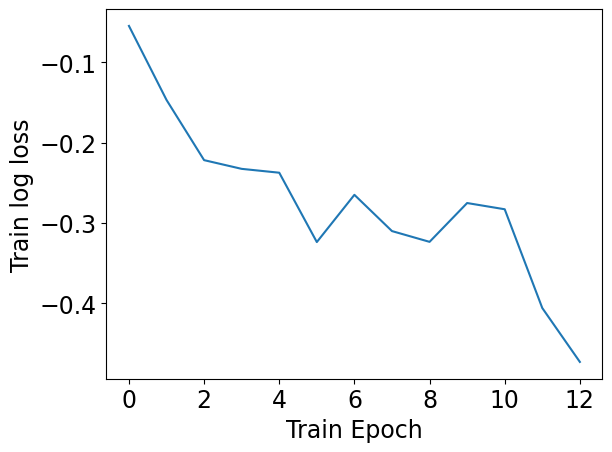

Time taken: 33.04s

Start of epoch 13
Augmenting time series lengths...
Avg training loss: 0.6176


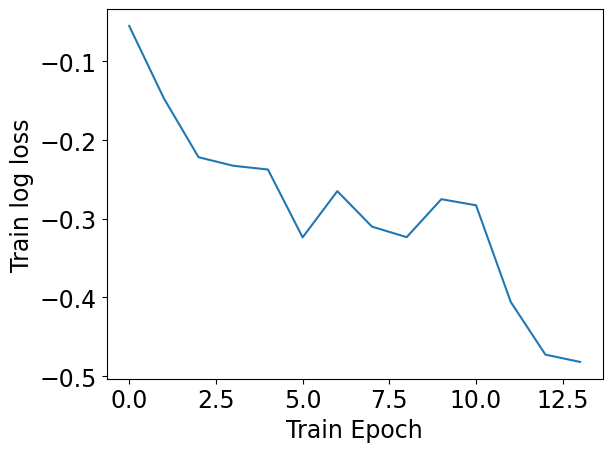

Time taken: 33.37s

Start of epoch 14
Augmenting time series lengths...
Avg training loss: 0.6706


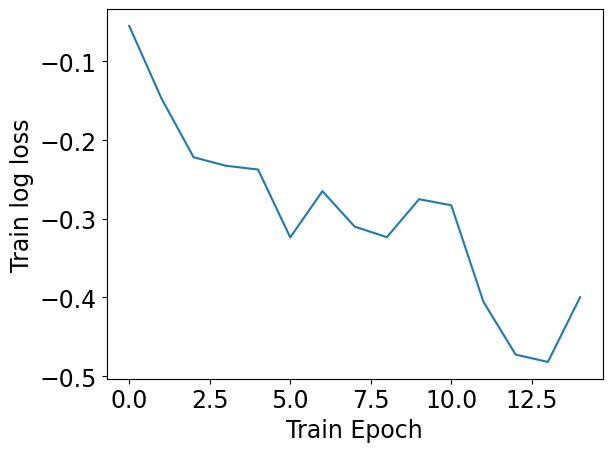

Time taken: 29.89s

Start of epoch 15
Augmenting time series lengths...
Avg training loss: 0.6060


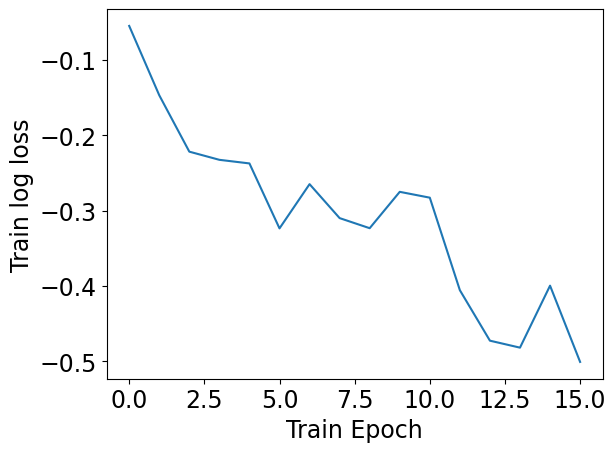

Time taken: 32.60s

Start of epoch 16
Augmenting time series lengths...
Avg training loss: 0.6149


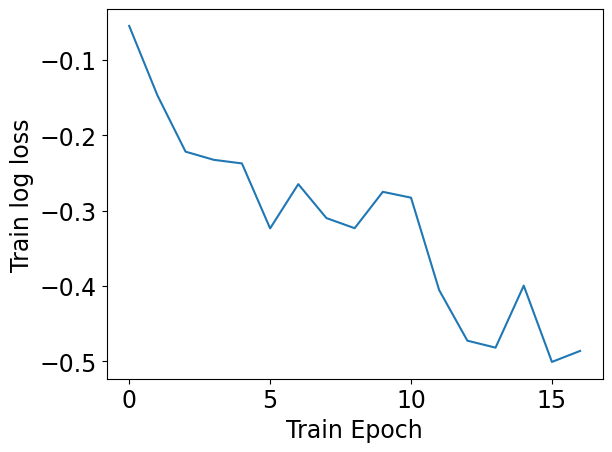

Time taken: 31.54s

Start of epoch 17
Augmenting time series lengths...
Avg training loss: 0.6747


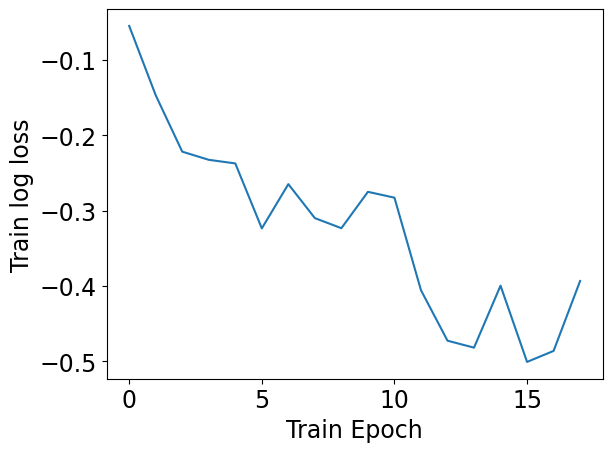

Time taken: 28.58s

Start of epoch 18
Augmenting time series lengths...
Avg training loss: 0.6636


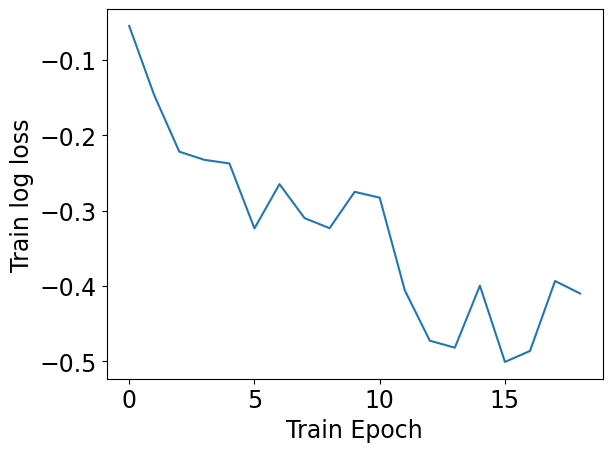

Time taken: 28.00s

Start of epoch 19
Augmenting time series lengths...
Avg training loss: 0.5353


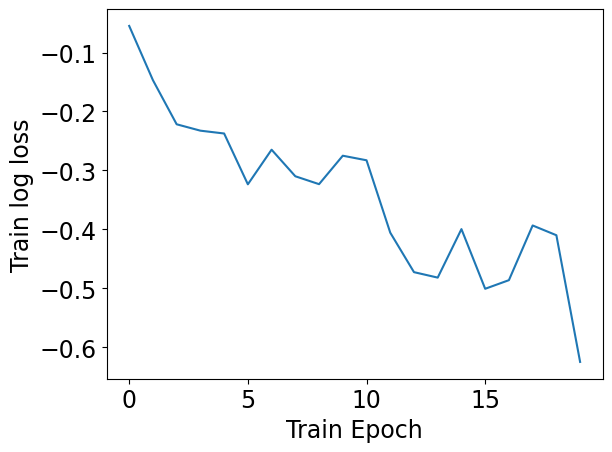

Time taken: 34.32s

Start of epoch 20
Augmenting time series lengths...
Avg training loss: 0.5404


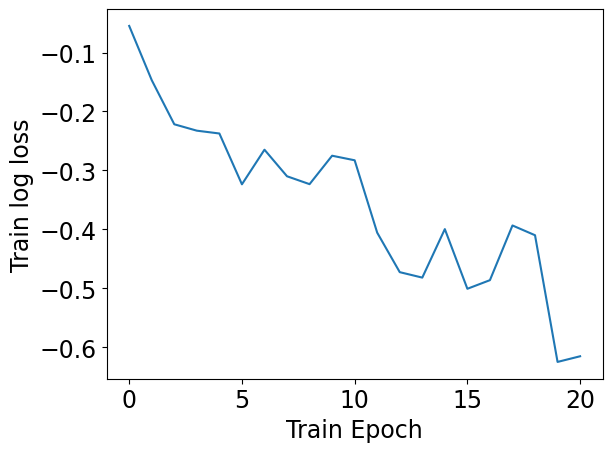

Time taken: 32.97s

Start of epoch 21
Augmenting time series lengths...
Avg training loss: 0.5727


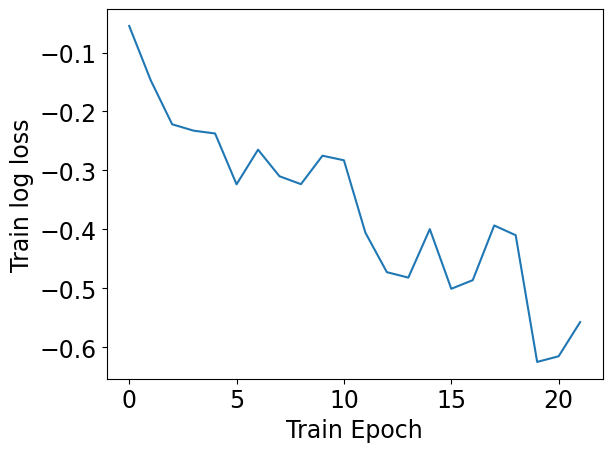

Time taken: 31.01s

Start of epoch 22
Augmenting time series lengths...
Avg training loss: 0.5624


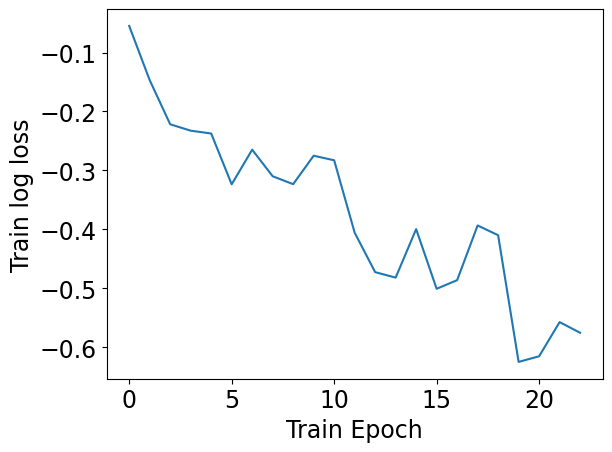

Time taken: 31.75s

Start of epoch 23
Augmenting time series lengths...
Avg training loss: 0.4935


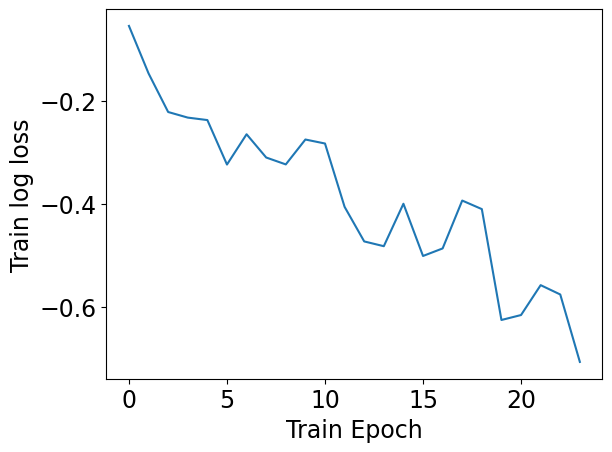

Time taken: 34.69s

Start of epoch 24
Augmenting time series lengths...
Avg training loss: 0.5266


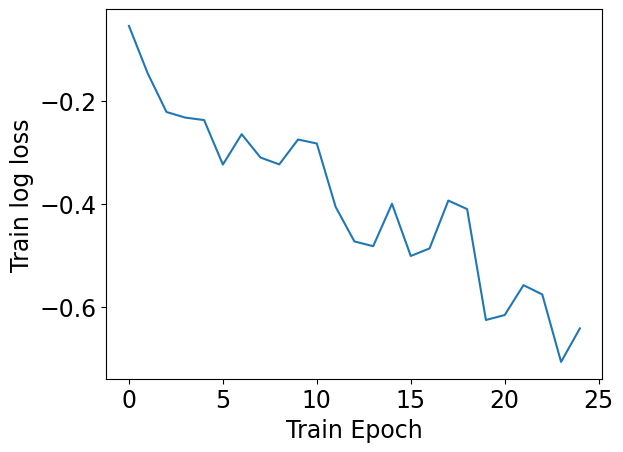

Time taken: 33.02s

Start of epoch 25
Augmenting time series lengths...
Avg training loss: 0.5027


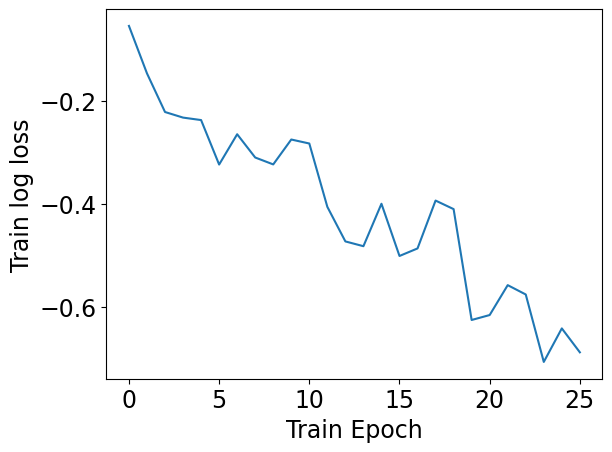

Time taken: 32.90s

Start of epoch 26
Augmenting time series lengths...
Avg training loss: 0.7507


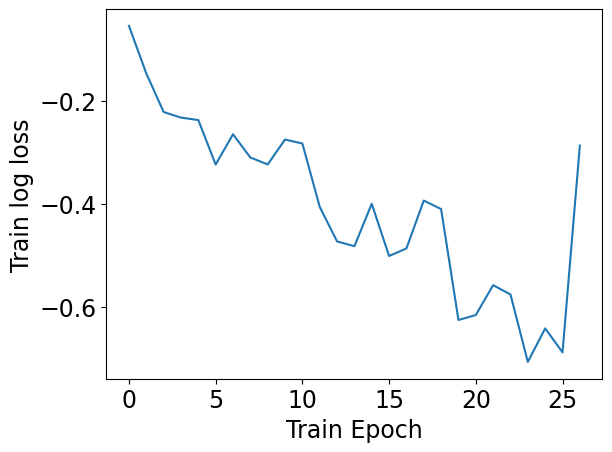

Time taken: 26.04s

Start of epoch 27
Augmenting time series lengths...
Avg training loss: 0.4919


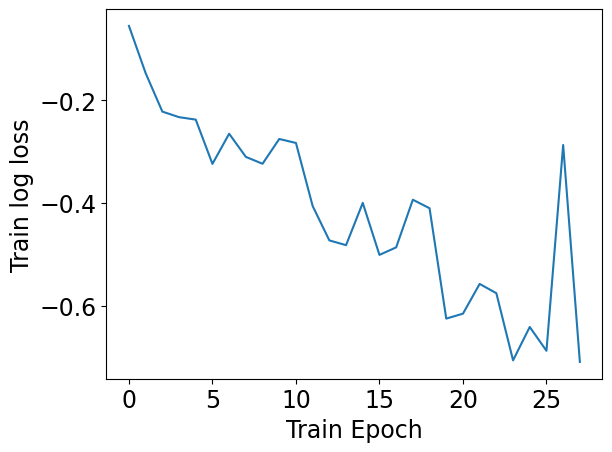

Time taken: 33.67s

Start of epoch 28
Augmenting time series lengths...
Avg training loss: 0.5100


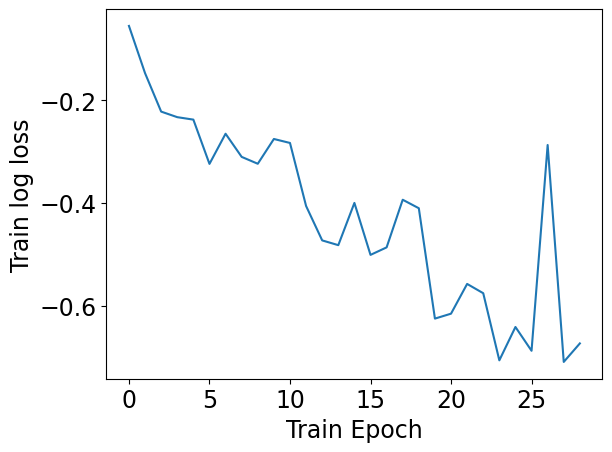

Time taken: 31.01s

Start of epoch 29
Augmenting time series lengths...
Avg training loss: 0.7407


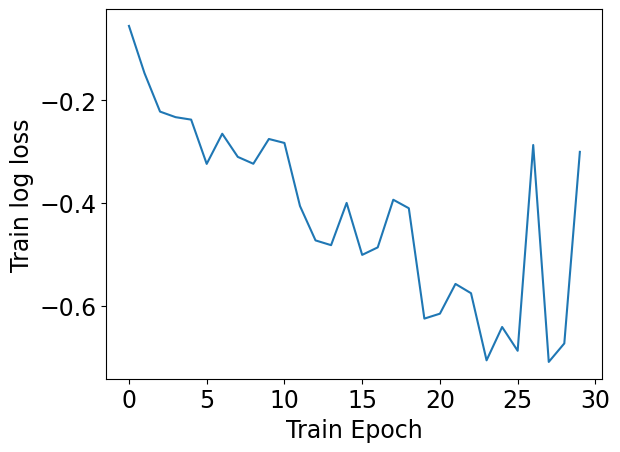

Time taken: 26.05s

Start of epoch 30
Augmenting time series lengths...
Avg training loss: 0.6566


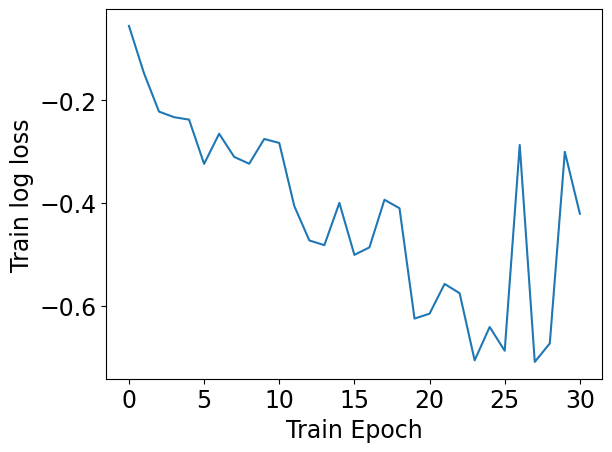

Time taken: 27.59s

Start of epoch 31
Augmenting time series lengths...
Avg training loss: 0.5191


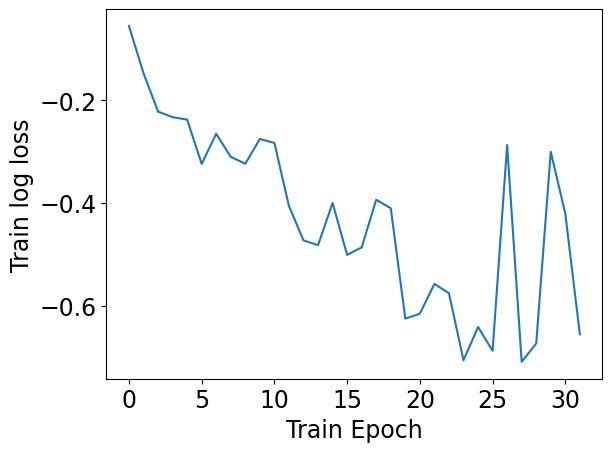

Time taken: 30.23s

Start of epoch 32
Augmenting time series lengths...
Avg training loss: 0.6485


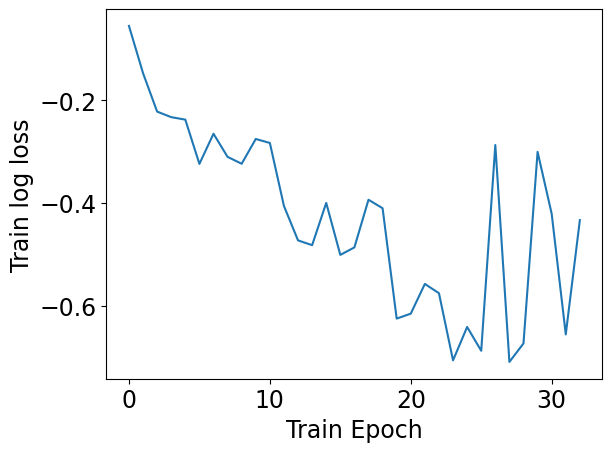

Time taken: 27.22s

Start of epoch 33
Augmenting time series lengths...
Avg training loss: 0.4605


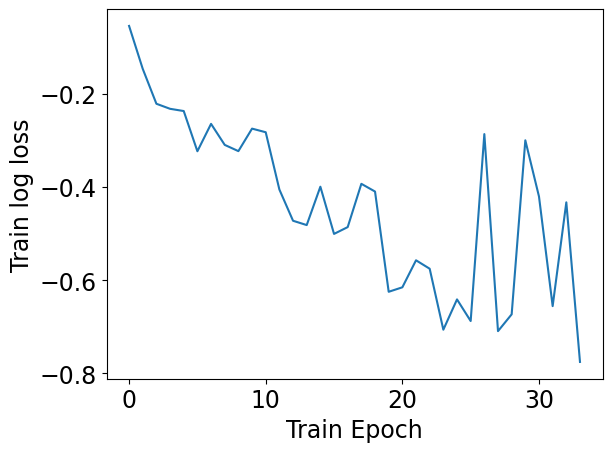

Time taken: 33.99s

Start of epoch 34
Augmenting time series lengths...
Avg training loss: 0.7406


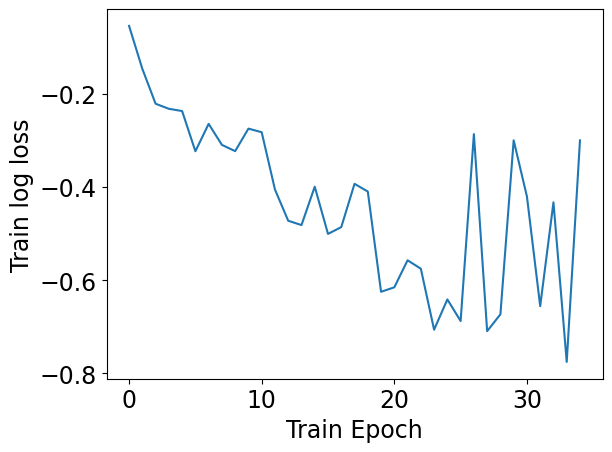

Time taken: 25.73s

Start of epoch 35
Augmenting time series lengths...
Avg training loss: 0.5124


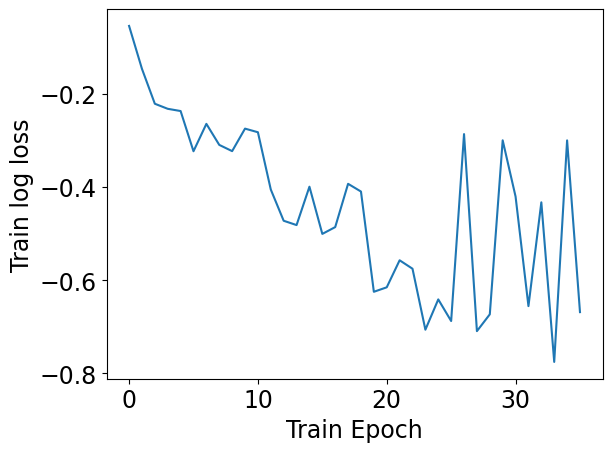

Time taken: 29.48s

Start of epoch 36
Augmenting time series lengths...
Avg training loss: 0.4114


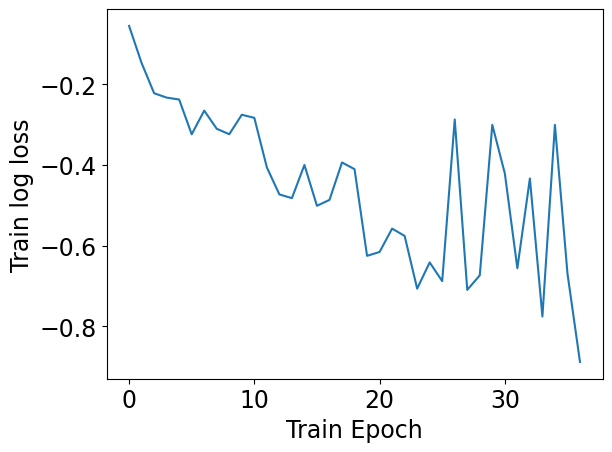

Time taken: 34.28s

Start of epoch 37
Augmenting time series lengths...
Avg training loss: 0.5987


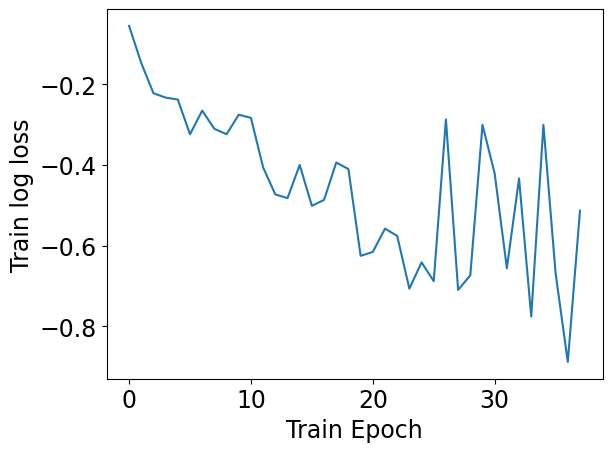

Time taken: 27.66s

Start of epoch 38
Augmenting time series lengths...
Avg training loss: 0.4468


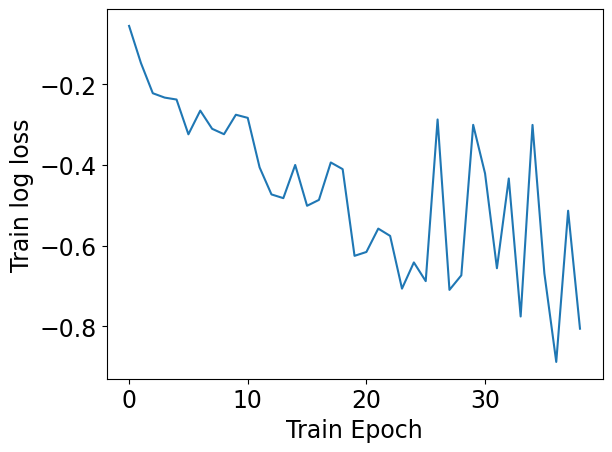

Time taken: 33.15s

Start of epoch 39
Augmenting time series lengths...
Avg training loss: 0.5239


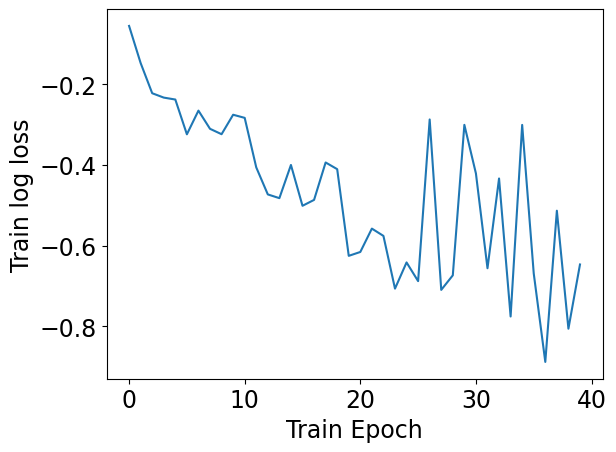

Time taken: 29.07s

Start of epoch 40
Augmenting time series lengths...
Avg training loss: 0.5585


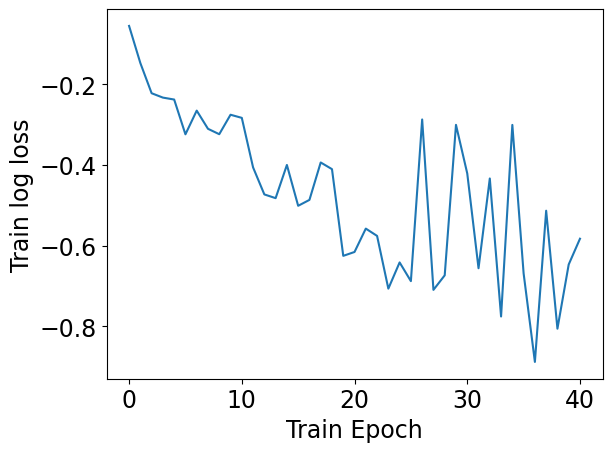

Time taken: 28.25s

Start of epoch 41
Augmenting time series lengths...
Avg training loss: 0.7819


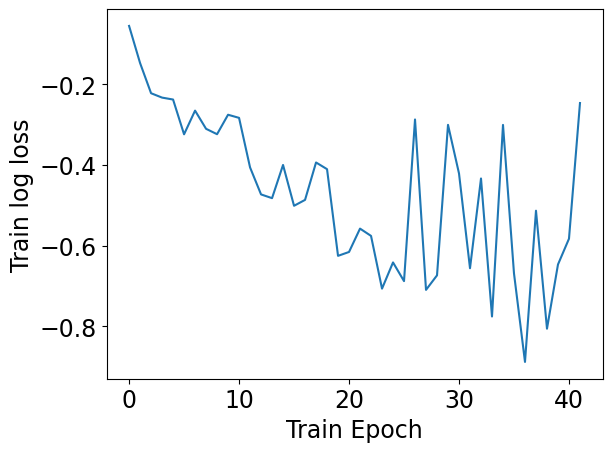

Time taken: 25.87s

Start of epoch 42
Augmenting time series lengths...
Avg training loss: 0.4095


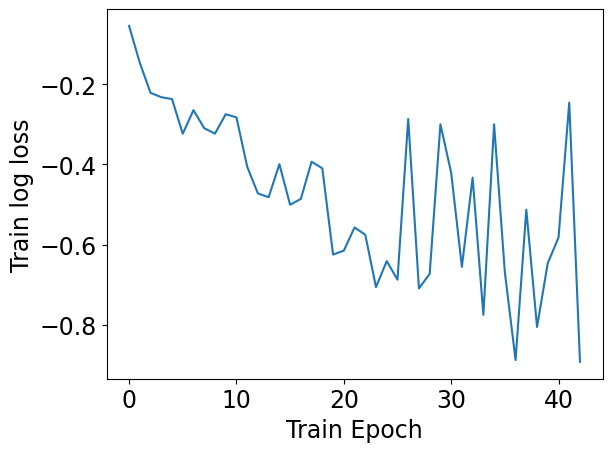

Time taken: 33.72s

Start of epoch 43
Augmenting time series lengths...
Avg training loss: 0.4090


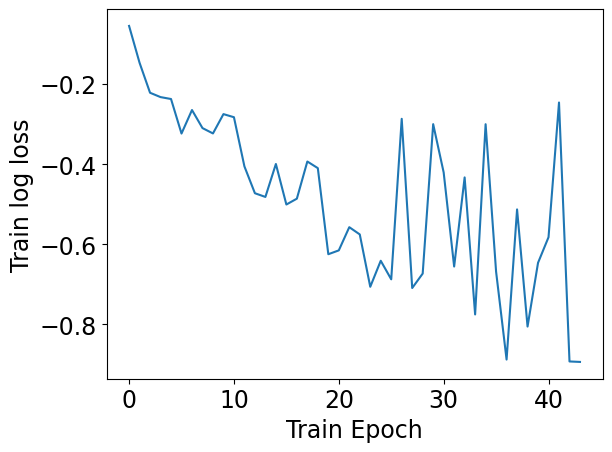

Time taken: 32.49s

Start of epoch 44
Augmenting time series lengths...
Avg training loss: 0.4006


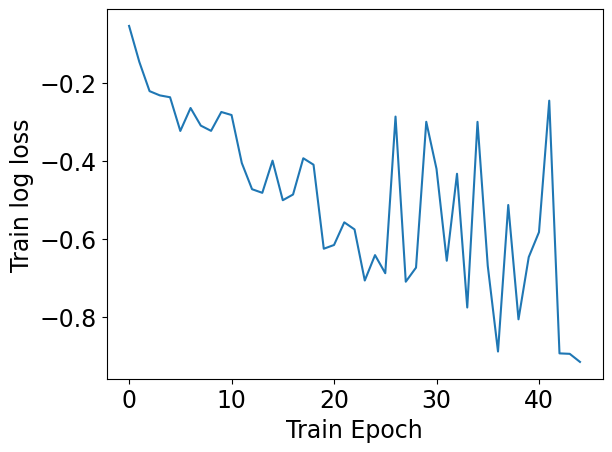

Time taken: 33.19s

Start of epoch 45
Augmenting time series lengths...
Avg training loss: 0.8287


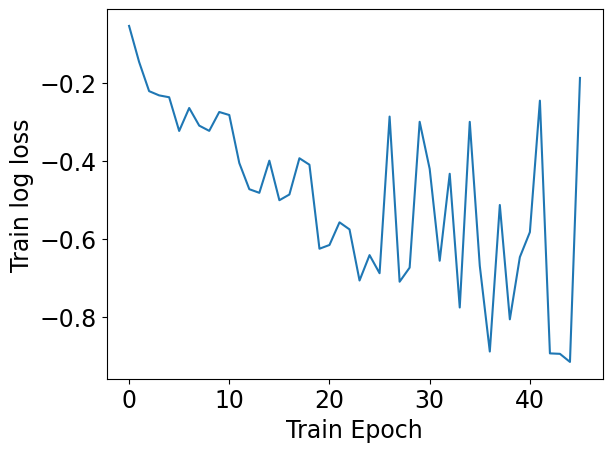

Time taken: 25.12s

Start of epoch 46
Augmenting time series lengths...
Avg training loss: 0.4057


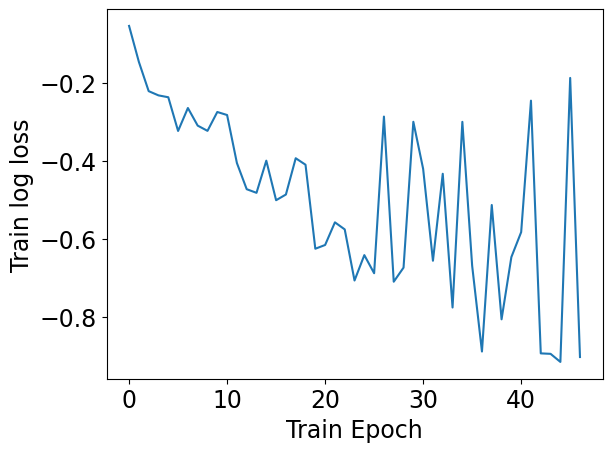

Time taken: 33.49s

Start of epoch 47
Augmenting time series lengths...
Avg training loss: 0.4965


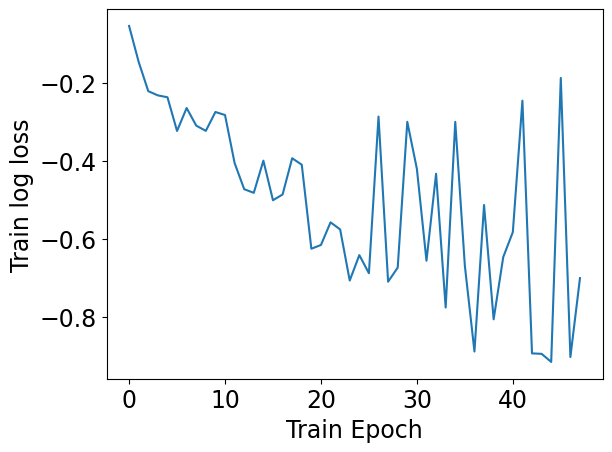

Time taken: 29.30s

Start of epoch 48
Augmenting time series lengths...
Avg training loss: 0.4394


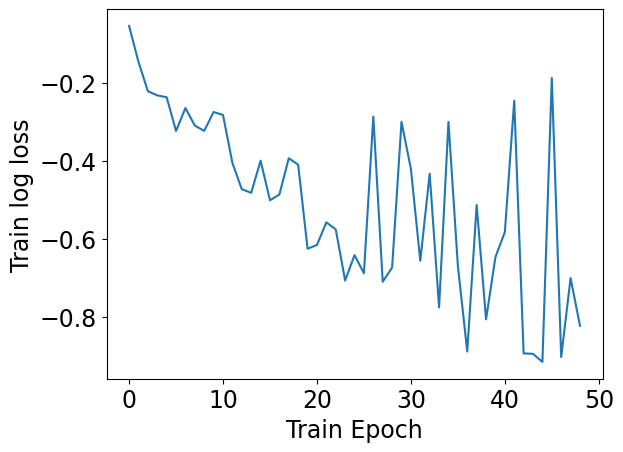

Time taken: 30.69s

Start of epoch 49
Augmenting time series lengths...
Avg training loss: 0.3786


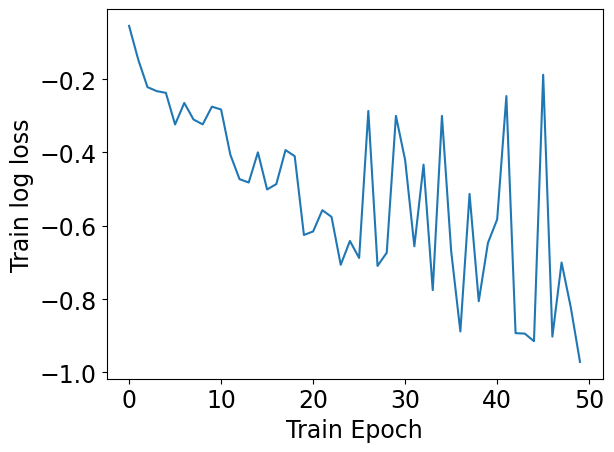

Time taken: 32.72s


In [35]:
avg_train_losses = []
for epoch in range(num_epochs):
    
    print(f"\nStart of epoch {epoch}")
    start_time = time.time()

    print("Augmenting time series lengths...")
    
    # Create the augmented data set for training
    X_ts_train_aug, X_static_train_aug, Y_train_aug, astrophysical_classes_train_aug = get_augmented_data(X_ts_train, X_static_train, Y_train, astrophysical_classes_train)
    train_dataset =  tf.data.Dataset.from_tensor_slices((X_ts_train_aug, X_static_train_aug, Y_train_aug, astrophysical_classes_train_aug)).batch(batch_size)
    
    # Array to keep tracking of the training loss
    train_loss_values = []
    
    # Iterate over the batches of the dataset.
    for step, (x_ts_batch_train, x_static_batch_train, y_batch_train, a_class_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_ts_batch_train, x_static_batch_train, y_batch_train)
    
    # Log the avg train loss
    avg_train_loss = np.mean(loss_value)
    avg_train_losses.append(avg_train_loss)
    print(f"Avg training loss: {float(avg_train_loss):.4f}")
    
    print(f"Time taken: {time.time() - start_time:.2f}s")
    model.save(f"models/lstm_epoch_{epoch}.h5")

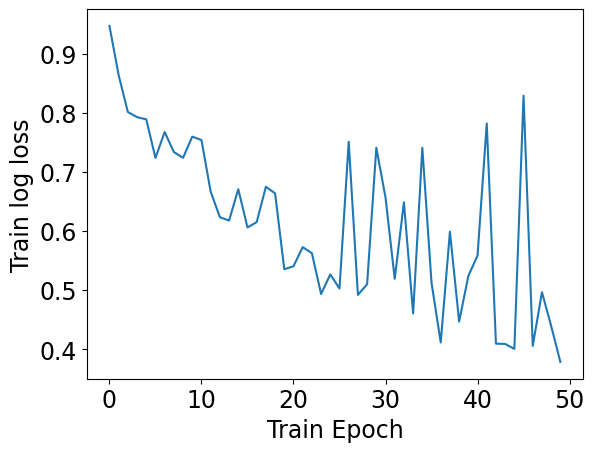

In [41]:
plt.plot(range(epoch + 1), avg_train_losses)
plt.xlabel("Train Epoch")
plt.ylabel("Train log loss")
plt.show()

Save the model with the smalles training loss

In [36]:
best_model_epoch = np.argmin(avg_train_losses)
print(f"Best model based on training loss was at epoch {best_model_epoch}")
loaded_model = keras.models.load_model(f"models/lstm_epoch_{best_model_epoch}.h5", compile=False)
loaded_model.save(f"models/best_model.h5")

Best model based on training loss was at epoch 49


## Load the saved model and validate everthing looks okay

In [37]:
best_model = keras.models.load_model(f"models/best_model.h5", compile=False)

In [38]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [114]:
for f in fractions:

    print(f'Running inference for {int(f*100)}% light curves...')

    x1, x2, y_true, _ = get_augmented_data(X_ts_val, X_static_val, Y_val, astrophysical_classes_val, fraction=f)
    
    # Run inference on these
    y_pred = saved_model.predict([x1, x2])

    # Get the conditional probabilities
    _, pseudo_conditional_probabilities = get_conditional_probabilites(y_pred, tree)
    
    print(f'For {int(f*100)}% of the light curve, these are the statistics')
    
    save_all_cf_and_rocs(y_true, y_pred, tree, f)
    plt.close()

Running inference for 10% light curves...
332/332 [==============================] - 1s 3ms/step
For 10% of the light curve, these are the statistics
              precision    recall  f1-score   support

   Transient       0.92      1.00      0.96      7312
    Variable       1.00      0.80      0.89      3287

    accuracy                           0.94     10599
   macro avg       0.96      0.90      0.92     10599
weighted avg       0.94      0.94      0.93     10599

              precision    recall  f1-score   support

          SN       1.00      0.54      0.70       667
        Fast       0.72      0.93      0.82      1372
        Long       0.73      0.71      0.72      2627
    Periodic       1.00      0.86      0.92      2620
         AGN       0.77      0.85      0.81      3313

    accuracy                           0.81     10599
   macro avg       0.84      0.78      0.79     10599
weighted avg       0.82      0.81      0.81     10599

               precision    recall

In [113]:
for f in fractions:

    print(f'Running inference for {int(f*100)}% light curves...')

    x1, x2, y_true, _ = get_augmented_data(X_ts_val, X_static_val, Y_val, astrophysical_classes_val, fraction=f)
    
    # Run inference on these
    y_pred = best_model.predict([x1, x2])

    # Get the predictions at the leaf
    _, pseudo_conditional_probabilities = get_conditional_probabilites(y_pred, tree)

    y_pred_label = np.argmax(pseudo_conditional_probabilities[:, -19:], axis=1)
    y_true_label = np.argmax(y_true[:, -19:], axis=1)

    # Print the stats
    print(f'For {int(f*100)}% of the light curve, these are the statistics')
    report = classification_report(y_true_label, y_pred_label, target_names=list(loss_object.level_order_nodes)[-19:])
    print(report)

    # Make plots
    leaf_labels = list(loss_object.level_order_nodes)[-19:]
    plot_title = f"~{f * 100}% of each LC visible"
    cf_plot_file = f"gif/leaf_cf/{f}.png"
    roc_plot_file = f"gif/leaf_roc/{f}.png"
    
    plot_confusion_matrix(y_true_label, y_pred_label, leaf_labels, plot_title, cf_plot_file)
    plt.close()
    plot_roc_curves(y_true[:, -19:], pseudo_conditional_probabilities[:, -19:], leaf_labels, plot_title, roc_plot_file)
    plt.close()

Running inference for 10% light curves...
332/332 [==============================] - 1s 3ms/step
For 10% of the light curve, these are the statistics
               precision    recall  f1-score   support

          AGN       0.99      0.27      0.43       667
         SNIa       0.29      0.12      0.17       672
       SNIb/c       0.24      0.21      0.23       669
        SNIax       0.24      0.26      0.25       667
      SNI91bg       0.43      0.35      0.39       629
         SNII       0.23      0.58      0.33       676
           KN       0.25      0.58      0.35       190
  Dwarf Novae       0.35      0.96      0.51       409
        uLens       0.58      0.36      0.44       664
M-dwarf Flare       0.33      0.05      0.08       109
         SLSN       0.50      0.51      0.51       617
          TDE       0.27      0.21      0.23       617
         ILOT       0.37      0.36      0.37       354
         CART       0.15      0.13      0.14       415
         PISN       0.70

## Making a cool animation:

In [111]:
cf_files = [f"gif/leaf_cf/{f}.png" for f in fractions]
make_gif(cf_files, 'gif/leaf_cf/leaf_cf.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [112]:
roc_files = [f"gif/leaf_roc/{f}.png" for f in fractions]
make_gif(roc_files, 'gif/leaf_roc/leaf_roc.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [115]:
cf_files = [f"gif/level_1_cf/{f}.png" for f in fractions]
make_gif(cf_files, 'gif/level_1_cf/level_1_cf.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [116]:
roc_files = [f"gif/level_1_roc/{f}.png" for f in fractions]
make_gif(roc_files, 'gif/level_1_roc/level_1_roc.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [106]:
cf_files = [f"gif/level_2_cf/{f}.png" for f in fractions]
make_gif(cf_files, 'gif/level_2_cf/level_2_cf.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [107]:
roc_files = [f"gif/level_2_roc/{f}.png" for f in fractions]
make_gif(roc_files, 'gif/level_2_roc/level_2_roc.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [108]:
cf_files = [f"gif/level_3_cf/{f}.png" for f in fractions]
make_gif(cf_files, 'gif/level_3_cf/level_3_cf.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [109]:
roc_files = [f"gif/level_3_roc/{f}.png" for f in fractions]
make_gif(roc_files, 'gif/level_3_roc/level_3_roc.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


For the love of everthing that is good in this world, please use a different notebook for testing and genearting statistics. Keep this notebook simple enought to be converted into a script. 